# Credit Card Fraud Detection

## Problem Statement:

The Credit Card Fraud Detection Problem includes modeling past credit card transactions with the knowledge of the ones that turned out to be fraud. This model is then used to identify whether a new transaction is fraudulent or not. Our aim here is to detect the fraudulent transactions while minimizing the incorrect fraud classifications.

## Data Description

The dataset contains transactions made by credit cards in September 2013 by European cardholders.
This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.

It contains only numerical input variables which are the result of a PCA transformation. Unfortunately, due to confidentiality issues, we cannot provide the original features and more background information about the data. Features V1, V2, … V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'. Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature 'Amount' is the transaction Amount, this feature can be used for example-dependant cost-sensitive learning. Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise.


## Import Libraries

In [1]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy import stats
import tensorflow as tf
import seaborn as sns
from pylab import rcParams
from sklearn.model_selection import train_test_split
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers

In [2]:
!pip install tensorflow

## Loading the Data

The dataset is taken from the [Kaggle](https://www.kaggle.com/mlg-ulb/creditcardfraud) website.

In [3]:
df = pd.read_csv('creditcard.csv')

In [4]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [5]:
df.sample(5)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
207828,136849.0,-0.675347,0.491543,-0.299686,-0.369913,1.520477,-0.806435,0.497727,-0.953603,-0.313002,...,1.159825,1.102473,-0.562217,-0.392714,0.004094,0.050388,0.291512,0.146681,10.00,0
251270,155290.0,2.110787,-1.116341,-0.485130,-0.951400,-1.176963,-0.411857,-1.141613,0.108157,0.074763,...,-0.022681,-0.184196,0.342000,-0.404159,-0.542313,-0.481060,-0.003877,-0.054341,23.96,0
208201,137014.0,1.888840,-0.137718,-1.743910,0.301084,0.261520,-0.572487,0.039039,-0.067196,0.734473,...,-0.166832,-0.399038,0.169153,0.652229,-0.095975,-0.150126,-0.024342,-0.015067,60.00,0
247877,153721.0,2.032522,0.301737,-2.038658,1.121259,0.911769,-0.909677,0.803821,-0.429925,-0.199488,...,0.131186,0.418774,-0.012279,0.609965,0.494098,-0.511043,-0.037061,-0.053224,29.85,0
15338,26721.0,1.486381,-0.347510,-0.415518,-0.766293,-0.459213,-1.141126,-0.090206,-0.337076,-1.005217,...,0.148081,0.333058,-0.215745,-0.092514,0.834686,-0.051178,-0.034019,-0.005047,12.00,0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

# Exploratory data analysis

In [7]:
df.shape

(284807, 31)

In [8]:
df.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

31 columns, 2 of which are Time and Amount. The rest are output from the PCA transformation

In [9]:
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,3.919560e-15,5.688174e-16,-8.769071e-15,2.782312e-15,-1.552563e-15,2.010663e-15,-1.694249e-15,-1.927028e-16,-3.137024e-15,...,1.537294e-16,7.959909e-16,5.367590e-16,4.458112e-15,1.453003e-15,1.699104e-15,-3.660161e-16,-1.206049e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


### Handling missing values

In [10]:
df.isnull().values.any()

False

We can see that there is no missing values in any of the columns. Hence, there is no problem with null values in the entire dataset.

### Checking the distribution of the 'Class' column

In [11]:
count_classes = df['Class'].value_counts(sort=True)
count_classes

0    284315
1       492
Name: Class, dtype: int64

In [12]:
Normal = df[df['Class'] == 0 ]
Normal.shape

(284315, 31)

In [13]:
Fraud = df[df['Class'] == 1]
Fraud.shape

(492, 31)

Text(0, 0.5, 'Frequency')

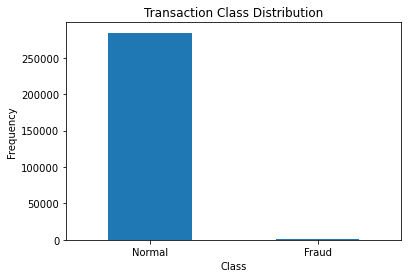

In [14]:
LABELS = ["Normal", "Fraud"]

count_classes.plot(kind = 'bar', rot=0)
plt.title("Transaction Class Distribution")
plt.xticks(range(2), LABELS)
plt.xlabel("Class")
plt.ylabel("Frequency")

In [15]:
df['Class'].value_counts(normalize=True)

0    0.998273
1    0.001727
Name: Class, dtype: float64

We have a highly imbalanced dataset on our hands(Only 0.17% transactions are fraudulent whereas 99.8% transactions are normal). Normal transactions overwhelm the fraudulent ones by a large margin.

Different amount of money used in different transaction classes

In [16]:
Normal['Amount'].describe()

count    284315.000000
mean         88.291022
std         250.105092
min           0.000000
25%           5.650000
50%          22.000000
75%          77.050000
max       25691.160000
Name: Amount, dtype: float64

In [17]:
Fraud['Amount'].describe()

count     492.000000
mean      122.211321
std       256.683288
min         0.000000
25%         1.000000
50%         9.250000
75%       105.890000
max      2125.870000
Name: Amount, dtype: float64

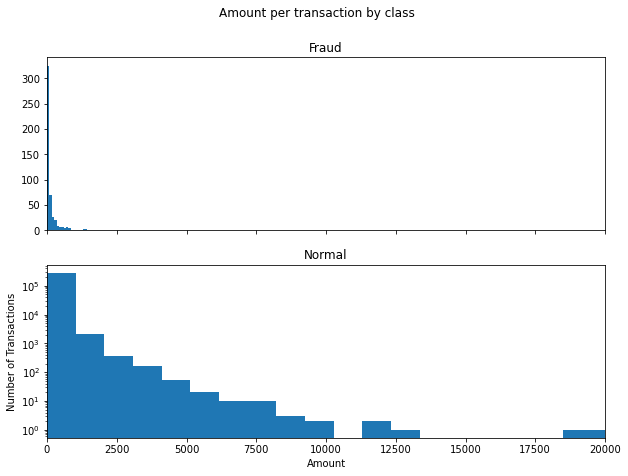

In [18]:
f, (ax1, ax2) = plt.subplots(2, 1, figsize=(10,7), sharex=True)
f.suptitle('Amount per transaction by class')


ax1.hist(Fraud['Amount'], bins = 25)
ax1.set_title('Fraud')

ax2.hist(Normal['Amount'], bins = 25)
ax2.set_title('Normal')

plt.xlabel('Amount')
plt.ylabel('Number of Transactions')
plt.xlim((0, 20000))
plt.yscale('log')

plt.show()

We can see that the fraudulent transctions are mostly densed in the lower range of amount, whereas the non-fraudulent transctions are spreaded throughout low to high range of amount.

Let's check if there is any specific pattern for the fraudulent and non-fraudulent transctions with respect to Time.

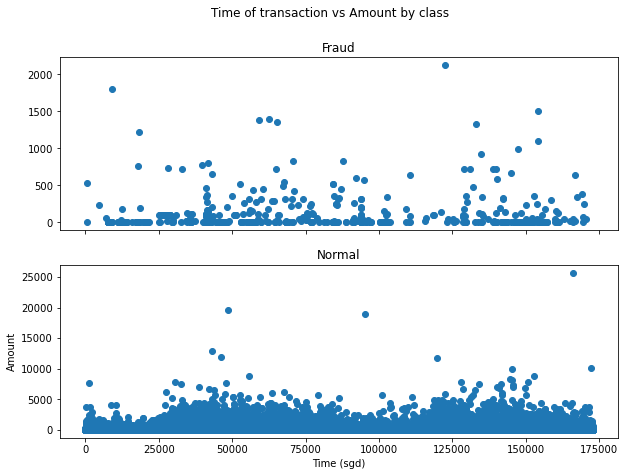

In [19]:
f, (ax1, ax2) = plt.subplots(2, 1, figsize=(10,7), sharex=True)
f.suptitle('Time of transaction vs Amount by class')

ax1.scatter(Fraud['Time'], Fraud['Amount'])
ax1.set_title('Fraud')

ax2.scatter(Normal['Time'], Normal['Amount'])
ax2.set_title('Normal')

plt.xlabel('Time (sgd)')
plt.ylabel('Amount')
plt.show()

It does not seem like the time of transaction really matters. Hence, we can drop the Time column.

In [20]:
# Dropping the Time column
df.drop('Time', axis=1, inplace=True)

In [21]:
df.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


### Feature correlation heatmap

Plotting a heatmap to gain a high level view of relationships amongst the features.

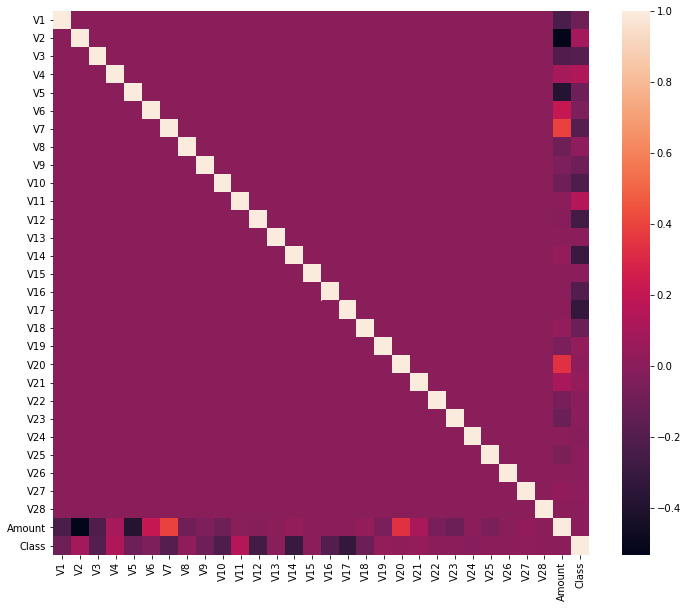

In [22]:
plt.figure(figsize=(12,10))
sns.heatmap(df.corr())
plt.show();

The correlation matrix shows that none of the V1 trough V28 PCA components have any correlation to each other however if we observe Class has some form positive and negative correlations with the V components but has no correlation with the Amount.

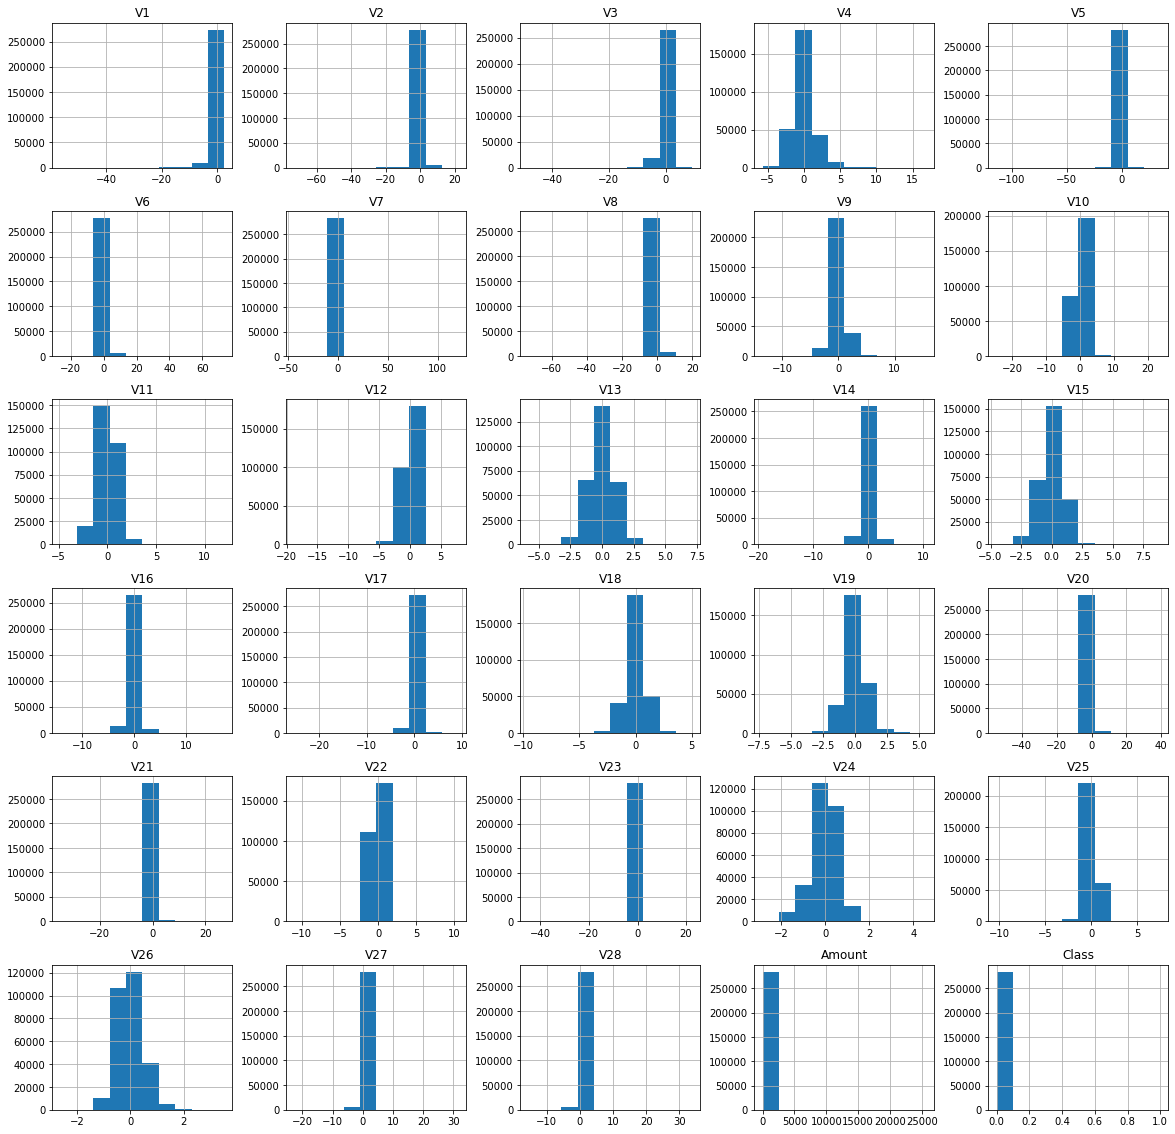

In [23]:
df.hist(figsize=(20, 20));

# Data Pre-processing

## Feature Scaling